# Here we will plot the slope and the knee frqeuency per subject for each sleep stage 

In [24]:
import os
from pathlib import Path
import numpy as np
import mne
import pandas as pd

# Use neurodsp for convenience
from neurodsp.plts import plot_time_series, plot_power_spectra
from neurodsp.spectral import compute_spectrum

# Import fooof for checking model fits
from fooof import FOOOF
from fooof import FOOOFGroup

# KNEE freqs
from fooof.utils.params import compute_knee_frequency
from fooof.utils.download import load_fooof_data

# Plotting functions
from spiketools.plts.utils import make_axes
import matplotlib.pyplot as plt
import seaborn


# GET PATHS

In [25]:
# get the staging list
path_stage = Path('/home/b1044271/EEGsleep/SleepStaging/mat/mne2/')
stage_files = os.listdir(path_stage)
stage_files = [file for file in stage_files]
stage_files = sorted(stage_files)

# get the subjects list
Data_path = '/home/b1044271/Columbia/Preprocessed/Better_ica/'
subj_files = os.listdir(Data_path)
subj_files = [file for file in subj_files]
subj_files = sorted(subj_files)


# Setting parameters

In [84]:
# Settings for the analyses
SETTINGS_B = { 'method' : 'welch', 'average' : 'mean', 'fmin' :0.1, 'fmax': 45}
path_results = Path('/home/b1044271/Columbia/Results/April23')

f_min = 1
f_max = 45
t     = 15
fs    = 250

SETTINGS_W  = { 'method' : 'welch', 'average' : 'mean', 'fmin' :f_min , 'fmax':f_max, 'n_fft': fs*t, 'n_overlap': fs*t*0.5}
SETTINGS_F1 = {'max_n_peaks':8, 'aperiodic_mode':'knee'}
SETTINGS_F2 = {'max_n_peaks':8, 'aperiodic_mode':'fixed'}


# Empty vectors for storing data

In [85]:
W_Kn  = np.zeros([183,2000])*np.nan
W_Exp = np.zeros([183,2000])*np.nan
W_Exp2 = np.zeros([183,2000])*np.nan

N1_Kn  = np.zeros([183,2000])*np.nan
N1_Exp = np.zeros([183,2000])*np.nan
N1_Exp2 = np.zeros([183,2000])*np.nan

N2_Kn  = np.zeros([183,2000])*np.nan
N2_Exp = np.zeros([183,2000])*np.nan
N2_Exp2 = np.zeros([183,2000])*np.nan

N3_Kn  = np.zeros([183,2000])*np.nan
N3_Exp = np.zeros([183,2000])*np.nan
N3_Exp2 = np.zeros([183,2000])*np.nan

R_Kn  = np.zeros([183,2000])*np.nan
R_Exp = np.zeros([183,2000])*np.nan
R_Exp2 = np.zeros([183,2000])*np.nan


# START Looping over subjects

In [86]:
# Helper function for paths, check for the path and creates ones if not found
def check_path(path):
    if not os.path.exists(path):
        os.mkdir(path)

check_path(path_results) # create a new folder for this analysis

In [ ]:
# Start function
i = 0
for x in subj_files:
    check_path(path_results / x[0:4]) # create subject folder
    EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file
    print('loaded')
    
    events = mne.read_events(Path(path_stage, stage_files[i])) #read staging markers
    epochs = mne.Epochs(EEG, events=events, tmin=-30, tmax=0)

#Now we select epochs and average over all epochs
    N1s = epochs['1']
    N2s = epochs['2']
    N3s = epochs['3']
    REs = epochs['5']
    AWs = epochs['0']
    
# Settings for PSD calculation using welch's
    N1={}
    N2={}
    N3={}
    AW={}
    RM={}

# calculate psd based on welch's method with differen freq range and diff time steps
    N1 = N1s.compute_psd(**SETTINGS_W) #N1
    N2 = N2s.compute_psd(**SETTINGS_W) #N2
    N3 = N3s.compute_psd(**SETTINGS_W)
    AW = AWs.compute_psd(**SETTINGS_W)
    RM = REs.compute_psd(**SETTINGS_W)
    
# FOOOF it
    fm1 = FOOOFGroup(**SETTINGS_F1)
    fm1.fit(N1._freqs, np.mean(N1._data,0), [N1._freqs[0] ,N1._freqs[-1]])
    
    fm2 = FOOOFGroup(**SETTINGS_F1)
    fm2.fit(N2._freqs, np.mean(N2._data,0), [N2._freqs[0] ,N2._freqs[-1]])
 
    fm3 = FOOOFGroup(**SETTINGS_F1)
    fm3.fit(N3._freqs, np.mean(N3._data,0), [N3._freqs[0] ,N3._freqs[-1]])
    
    fm4 = FOOOFGroup(**SETTINGS_F1)
    fm4.fit(RM._freqs, np.mean(RM._data,0), [RM._freqs[0] ,RM._freqs[-1]])
    
    fm5 = FOOOFGroup(**SETTINGS_F1)
    fm5.fit(AW._freqs, np.mean(AW._data,0), [AW._freqs[0] ,AW._freqs[-1]])
    
    fm6 = FOOOFGroup(**SETTINGS_F2)
    fm6.fit(N1._freqs, np.mean(N1._data,0), [N1._freqs[0] ,N1._freqs[-1]])
    
    fm7 = FOOOFGroup(**SETTINGS_F2)
    fm7.fit(N2._freqs, np.mean(N2._data,0), [N2._freqs[0] ,N2._freqs[-1]])
 
    fm8 = FOOOFGroup(**SETTINGS_F2)
    fm8.fit(N3._freqs, np.mean(N3._data,0), [N3._freqs[0] ,N3._freqs[-1]])
    
    fm9 = FOOOFGroup(**SETTINGS_F2)
    fm9.fit(RM._freqs, np.mean(RM._data,0), [RM._freqs[0] ,RM._freqs[-1]])
    
    fm10 = FOOOFGroup(**SETTINGS_F2)
    fm10.fit(AW._freqs, np.mean(AW._data,0), [AW._freqs[0] ,AW._freqs[-1]])
    
# parameters exctraction
    W_Kn[i,0:AW._data.shape[1]]  = fm5.get_params('aperiodic_params','knee')
    W_Exp[i,0:AW._data.shape[1]] = fm5.get_params('aperiodic_params','exponent')
    W_Exp2[i,0:AW._data.shape[1]] = fm10.get_params('aperiodic_params','exponent')
  
    R_Kn[i,0:RM._data.shape[1]]  = fm4.get_params('aperiodic_params','knee')
    R_Exp[i,0:RM._data.shape[1]] = fm4.get_params('aperiodic_params','exponent')
    R_Exp2[i,0:RM._data.shape[1]] = fm9.get_params('aperiodic_params','exponent')


    N1_Kn[i,0:N1._data.shape[1]]  = fm1.get_params('aperiodic_params','knee')
    N1_Exp[i,0:N1._data.shape[1]] = fm1.get_params('aperiodic_params','exponent')
    N1_Exp2[i,0:N1._data.shape[1]] = fm4.get_params('aperiodic_params','exponent')

    
    N2_Kn[i,0:N2._data.shape[1]]  = fm2.get_params('aperiodic_params','knee')
    N2_Exp[i,0:N2._data.shape[1]] = fm2.get_params('aperiodic_params','exponent')
    N2_Exp[i,0:RM._data.shape[1]] = fm7.get_params('aperiodic_params','exponent')

    
    N3_Kn[i,0:N3._data.shape[1]]  = fm3.get_params('aperiodic_params','knee')
    N3_Exp[i,0:N3._data.shape[1]] = fm3.get_params('aperiodic_params','exponent') 
    N3_Exp[i,0:N3._data.shape[1]] = fm8.get_params('aperiodic_params','exponent')
   
    i = i+1

/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/pymatreader/utils.py:122: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file


loaded
Not setting metadata
927 matching events found
Setting baseline interval to [-30.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 85 events and 7501 original time points ...


/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file
/tmp/ipykernel_3748199/2310224163.py:8: RuntimeWarning: This filename (/home/b1044271/EEGsleep/SleepStaging/mat/mne2/VP01_SS_250_mne.txt) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  events = mne.read_events(Path(path_stage, stage_files[i])) #read staging markers


0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 465 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 140 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 75 events and 7501 original time points ...
1 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 161 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Model fitting was unsuccessful.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/pymatreader/utils.py:122: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file


loaded
Not setting metadata
978 matching events found
Setting baseline interval to [-30.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 38 events and 7501 original time points ...


/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file
/tmp/ipykernel_3748199/2310224163.py:8: RuntimeWarning: This filename (/home/b1044271/EEGsleep/SleepStaging/mat/mne2/VP03_SS_250_mne.txt) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  events = mne.read_events(Path(path_stage, stage_files[i])) #read staging markers


0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 276 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 344 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 216 events and 7501 original time points ...
1 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 103 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.

Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.

Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/pymatreader/utils.py:122: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file


loaded
Not setting metadata
1021 matching events found
Setting baseline interval to [-30.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 50 events and 7501 original time points ...


/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file
/tmp/ipykernel_3748199/2310224163.py:8: RuntimeWarning: This filename (/home/b1044271/EEGsleep/SleepStaging/mat/mne2/VP04_SS_250_mne.txt) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  events = mne.read_events(Path(path_stage, stage_files[i])) #read staging markers


0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 352 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 223 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 219 events and 7501 original time points ...
1 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 176 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.

Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Model fitting was unsuccessful.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Model fitting was unsuccessful.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/pymatreader/utils.py:122: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file


loaded
Not setting metadata
954 matching events found
Setting baseline interval to [-30.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 78 events and 7501 original time points ...


/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file
/tmp/ipykernel_3748199/2310224163.py:8: RuntimeWarning: This filename (/home/b1044271/EEGsleep/SleepStaging/mat/mne2/VP05_SS_250_mne.txt) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  events = mne.read_events(Path(path_stage, stage_files[i])) #read staging markers


0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 390 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 242 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 94 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 149 events and 7501 original time points ...
1 bad epochs dropped
Effective window size : 15.000 (s)
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/pymatreader/utils.py:122: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file


loaded
Not setting metadata
963 matching events found
Setting baseline interval to [-30.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 62 events and 7501 original time points ...


/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file
/tmp/ipykernel_3748199/2310224163.py:8: RuntimeWarning: This filename (/home/b1044271/EEGsleep/SleepStaging/mat/mne2/VP06_SS_250_mne.txt) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  events = mne.read_events(Path(path_stage, stage_files[i])) #read staging markers


0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 229 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 383 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 96 events and 7501 original time points ...
1 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 192 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.

Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/pymatreader/utils.py:122: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file


loaded
Not setting metadata
968 matching events found
Setting baseline interval to [-30.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 78 events and 7501 original time points ...


/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file
/tmp/ipykernel_3748199/2310224163.py:8: RuntimeWarning: This filename (/home/b1044271/EEGsleep/SleepStaging/mat/mne2/VP07_SS_250_mne.txt) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  events = mne.read_events(Path(path_stage, stage_files[i])) #read staging markers


0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 328 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 278 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 155 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 128 events and 7501 original time points ...
1 bad epochs dropped
Effective window size : 15.000 (s)
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Model fitting was unsuccessful.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.

Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/pymatreader/utils.py:122: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file


loaded
Not setting metadata
1026 matching events found
Setting baseline interval to [-30.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 77 events and 7501 original time points ...


/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file
/tmp/ipykernel_3748199/2310224163.py:8: RuntimeWarning: This filename (/home/b1044271/EEGsleep/SleepStaging/mat/mne2/VP08_SS_250_mne.txt) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  events = mne.read_events(Path(path_stage, stage_files[i])) #read staging markers


0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 443 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 175 events and 7501 original time points ...
1 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 164 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 166 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.

/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/pymatreader/utils.py:122: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file


loaded
Not setting metadata
961 matching events found
Setting baseline interval to [-30.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 72 events and 7501 original time points ...


/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file
/tmp/ipykernel_3748199/2310224163.py:8: RuntimeWarning: This filename (/home/b1044271/EEGsleep/SleepStaging/mat/mne2/VP10_SS_250_mne.txt) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  events = mne.read_events(Path(path_stage, stage_files[i])) #read staging markers


0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 313 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 357 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 72 events and 7501 original time points ...
1 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 146 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.

Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/pymatreader/utils.py:122: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file


loaded
Not setting metadata
935 matching events found
Setting baseline interval to [-30.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 61 events and 7501 original time points ...


/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file
/tmp/ipykernel_3748199/2310224163.py:8: RuntimeWarning: This filename (/home/b1044271/EEGsleep/SleepStaging/mat/mne2/VP11_SS_250_mne.txt) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  events = mne.read_events(Path(path_stage, stage_files[i])) #read staging markers


0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 381 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 245 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 63 events and 7501 original time points ...
1 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 184 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/pymatreader/utils.py:122: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file


loaded
Not setting metadata
970 matching events found
Setting baseline interval to [-30.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 19 events and 7501 original time points ...


/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file
/tmp/ipykernel_3748199/2310224163.py:8: RuntimeWarning: This filename (/home/b1044271/EEGsleep/SleepStaging/mat/mne2/VP12_SS_250_mne.txt) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  events = mne.read_events(Path(path_stage, stage_files[i])) #read staging markers


0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 220 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 227 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 251 events and 7501 original time points ...
1 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 252 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.

/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/pymatreader/utils.py:122: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file


loaded
Not setting metadata
631 matching events found
Setting baseline interval to [-30.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 44 events and 7501 original time points ...


/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file
/tmp/ipykernel_3748199/2310224163.py:8: RuntimeWarning: This filename (/home/b1044271/EEGsleep/SleepStaging/mat/mne2/VP13_SS_250_mne.txt) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  events = mne.read_events(Path(path_stage, stage_files[i])) #read staging markers


0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 207 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 255 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 30 events and 7501 original time points ...
1 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 94 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.

Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/pymatreader/utils.py:122: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file


loaded
Not setting metadata
965 matching events found
Setting baseline interval to [-30.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 63 events and 7501 original time points ...


/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file
/tmp/ipykernel_3748199/2310224163.py:8: RuntimeWarning: This filename (/home/b1044271/EEGsleep/SleepStaging/mat/mne2/VP14_SS_250_mne.txt) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  events = mne.read_events(Path(path_stage, stage_files[i])) #read staging markers


0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 316 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 348 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 49 events and 7501 original time points ...
1 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 188 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/pymatreader/utils.py:122: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file


loaded
Not setting metadata
957 matching events found
Setting baseline interval to [-30.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 44 events and 7501 original time points ...


/tmp/ipykernel_3748199/2310224163.py:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file
/tmp/ipykernel_3748199/2310224163.py:8: RuntimeWarning: This filename (/home/b1044271/EEGsleep/SleepStaging/mat/mne2/VP15_SS_250_mne.txt) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  events = mne.read_events(Path(path_stage, stage_files[i])) #read staging markers


0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 345 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 227 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 51 events and 7501 original time points ...
1 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 289 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/pymatreader/utils.py:122: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


# KNEE FREQ CALC

In [45]:
# Compute knee frequency
Kn_W = compute_knee_frequency(W_Kn, W_Exp)
Kn_N1 = compute_knee_frequency(N1_Kn, N2_Exp)
Kn_N2 = compute_knee_frequency(N2_Kn, N2_Exp)
Kn_N3 = compute_knee_frequency(N3_Kn, N3_Exp)
Kn_R = compute_knee_frequency(R_Kn, R_Exp)

/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/utils/params.py:24: RuntimeWarning: invalid value encountered in power
  return knee ** (1./exponent)


# PLOTTING

/tmp/ipykernel_3748199/4052715577.py:1: RuntimeWarning: Mean of empty slice
  array_list2 = [np.nanmean(Kn_W,1),np.nanmean(Kn_N1,1), np.nanmean(Kn_N2,1), np.nanmean(Kn_N3,1), np.nanmean(Kn_R,1)]
/tmp/ipykernel_3748199/4052715577.py:2: RuntimeWarning: Mean of empty slice
  array_list3 = [np.nanmean(W_Exp,1), np.nanmean(N1_Exp,1), np.nanmean(N2_Exp,1), np.nanmean(N3_Exp,1), np.nanmean(R_Exp,1)]
/tmp/ipykernel_3748199/4052715577.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(titles)
/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/seaborn/categorical.py:3540: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_3748199/4052715577.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(titles)


<AxesSubplot: ylabel='Exponent'>

/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/seaborn/categorical.py:3540: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


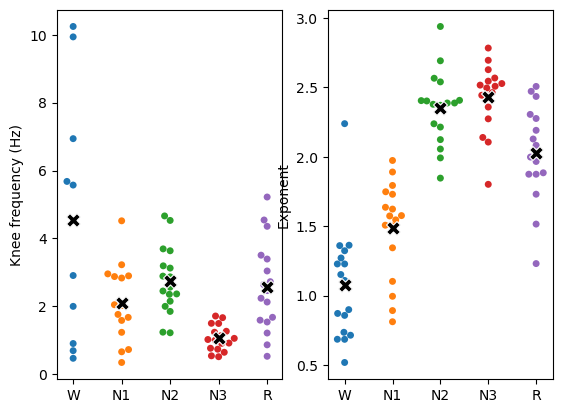

In [82]:
array_list2 = [np.nanmean(Kn_W,1),np.nanmean(Kn_N1,1), np.nanmean(Kn_N2,1), np.nanmean(Kn_N3,1), np.nanmean(Kn_R,1)]
array_list3 = [np.nanmean(W_Exp,1), np.nanmean(N1_Exp,1), np.nanmean(N2_Exp,1), np.nanmean(N3_Exp,1), np.nanmean(R_Exp,1)]
array_list4 = [np.nanmean(W_Exp,1), np.nanmean(N1_Exp,1), np.nanmean(N2_Exp,1), np.nanmean(N3_Exp,1), np.nanmean(R_Exp,1)]

titles =  ['W','N1', 'N2','N3','R']

fig = plt.figure(figsize=(15, 7))  

ax = fig.add_subplot(1, 3, 1)

ax = seaborn.swarmplot(data=array_list2)
ax.set( ylabel='Knee frequency (Hz)')
ax.set_xticklabels(titles)
seaborn.scatterplot(x=[0,1,2,3,4], y=np.mean(array_list2,1), marker='X', color='black', s=100, zorder=4, legend=False)

ax = fig.add_subplot(1, 3, 2)
ax = seaborn.swarmplot(data=array_list3)
ax.set( ylabel='Exponent')
ax.set_xticklabels(titles)
seaborn.scatterplot(x=[0,1,2,3,4], y=np.mean(array_list3,1), marker='X', color='black', s=100, zorder=4, legend=False)

ax = fig.add_subplot(1, 3, 3)
ax = seaborn.swarmplot(data=array_list4)
ax.set( ylabel='Exponent')
ax.set_xticklabels(titles)
seaborn.scatterplot(x=[0,1,2,3,4], y=np.mean(array_list4,1), marker='X', color='black', s=100, zorder=4, legend=False)

